Анализ комментариев

In [1]:
import re
import pandas as pd
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')# стоп-слова
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk_stopwords_ru = set(stopwords.words('russian'))
from nltk.probability import FreqDist
from pymystem3 import Mystem
morph = Mystem()
from wordcloud import WordCloud
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package punkt to /home/anna/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/anna/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /home/anna/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
def read_csv_to_pandas(file_name):
    df = pd.read_csv(file_name, index_col='id', parse_dates=['date'], sep=';', encoding='utf-8')
    return df

In [3]:
def open_object_list_in_pandas(object_list):
    data = [obj.__dict__ for obj in object_list]
    return pd.DataFrame(data)

In [4]:
comments = read_csv_to_pandas("comments.csv")
comments

,post_id,parent_id,date,user_id,sub_comments_count,text
id,,,,,,
217950,217949,0,2022-11-28 15:57:19,539146707,3,Не врать детям изначально и всё...
217951,217949,0,2022-11-28 16:11:40,77820205,0,У нас для этого тайный Санта
217953,217949,0,2022-11-28 16:17:33,359165766,5,В 10 лет рассказываю правду про Деда Мороза вс...
217954,217949,0,2022-11-28 16:37:28,361403784,2,Никому и ничего не рассказываю. До последнего ...
217955,217949,0,2022-11-28 16:38:29,73342270,4,А мне очень нравится идея. В свое время расска...
...,...,...,...,...,...,...
27,26,0,2015-01-06 21:08:04,179237651,0,Какое доброе фото!
32,17,0,2015-01-07 16:10:52,275560525,0,что-то до боли знакомое 😂 😆
85,17,0,2015-01-13 23:27:44,12979769,0,"ой, да, всякое бывает. 😊"


Проанализируем активность пользователей по годам: выполним распределение количества публикаций и комментариев по годам

In [5]:
#Данные берутся из таблиц posts и comments, т.к.текст постов и количество комментариев лежат в таблице posts, а кол-во подкомментариев в таблице comments
posts = read_csv_to_pandas("posts.csv")

#извлечение года из столбца с датами
posts['год'] = posts['date'].dt.year
comments['год'] = comments['date'].dt.year

#группировка и агрегация данных по годам для трёх разных показателей: количество публикаций, количество комментариев и количество подкомментариев
posts_by_year = posts.groupby('год')['text'].count().reset_index(name='количество публикаций')
comments_by_year = posts.groupby('год')['comments_count'].sum().reset_index(name='количество комментариев')
sub_comments_by_year = comments.groupby('год')['sub_comments_count'].sum().reset_index(name='количество подкомментариев')

#новый DataFrame, который объединяет данные о количестве комментариев и подкомментариев + добавляет новый столбец с общим количеством комментариев
all_comments_by_year = comments_by_year.copy()
all_comments_by_year['всего комментариев'] = comments_by_year['количество комментариев'] + sub_comments_by_year['количество подкомментариев']

# Объединяем posts_by_year и all_comments_by_year и убираем столбец "количество комментариев", т.к. выводим только общее количество комментариев
posts_comments_by_year = pd.merge(posts_by_year, all_comments_by_year, on='год')
posts_comments_by_year = posts_comments_by_year.drop(columns=['количество комментариев'])

# Заполняем пропущенные значения нулями
posts_comments_by_year = posts_comments_by_year.fillna(0)

# Удаляем строку со значениями для 2025 года, т.к. на момент сбора данных 2025 год еще не завершился, и публикаций, как и комментариев, мало
posts_comments_by_year = posts_comments_by_year[posts_comments_by_year['год'] != 2025]
print(posts_comments_by_year)

    год  количество публикаций  всего комментариев
0  2015                    898                2144
1  2016                    961                6847
2  2017                    969               13373
3  2018                    877               22442
4  2019                    716               69940
5  2020                    600               66759
6  2021                    470               63884
7  2022                    351               46758
8  2023                    204               22171
9  2024                    192               12258


Визуализация получившихся данных с помощью линейного графика из библиотеки seaborn

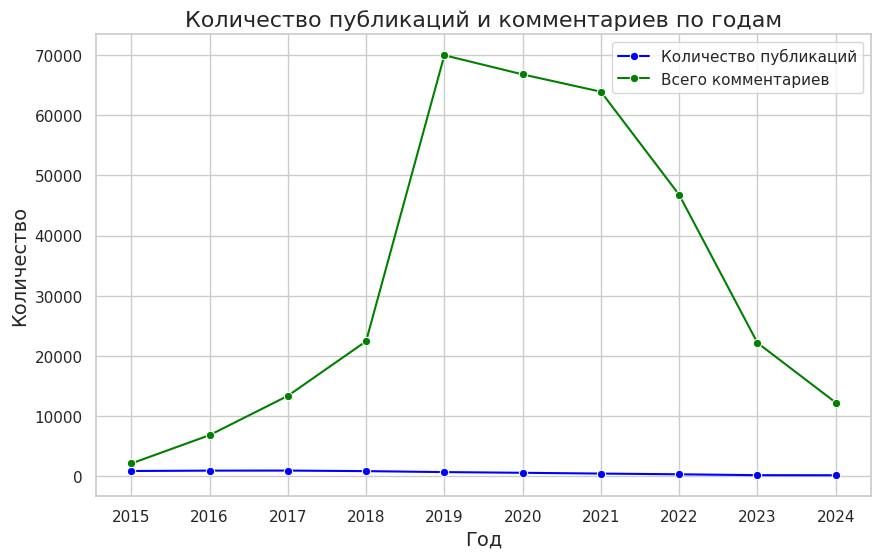

In [6]:
# Данные из итоговой таблицы
years = posts_comments_by_year['год']
publications = posts_comments_by_year['количество публикаций']
total_comments = posts_comments_by_year['всего комментариев']

# Настройка стиля seaborn
sns.set(style="whitegrid")

# Создаём график
plt.figure(figsize=(10, 6))

# Линейный график для количества публикаций
sns.lineplot(x='год', y='количество публикаций', data=posts_comments_by_year, marker='o', label='Количество публикаций', color='blue')

# Линейный график для общего количества комментариев
sns.lineplot(x='год', y='всего комментариев', data=posts_comments_by_year, marker='o', label='Всего комментариев', color='green')

# Настройки графика
plt.title('Количество публикаций и комментариев по годам', fontsize=16)
plt.xlabel('Год', fontsize=14)
plt.ylabel('Количество', fontsize=14)
plt.xticks(years)  # Отображаем все года на оси X
plt.legend()

# Показываем график
plt.show()

Предобработаем и лемматизируем комментарии. Выполним те же шаги, что мы делали для постов

In [7]:
def clean_text(text):
  try:
    text = re.sub(r'\[id\d+\|(.*)\],?', '', text)
    text = re.sub(r'\\n', ' ', text)
    text = re.sub(r'[^ а-яА-ЯеЕЁё0-9a-zA-Z\-]',' ',text)
    text = re.sub(r'(?![а-яА-ЯеЕЁё0-9a-zA-Z])-(\s+|$|\n)',' ',text)
    text = re.sub(r'(^|\s)+-(?<![а-яА-ЯеЕЁё0-9a-zA-Z])',' ',text)
    text = re.sub(r'\s{2,}', ' ', text)
    text = text.lower()
    text = text.strip()
    return text
  except:
    None

In [8]:
comments['cleaned_text'] = comments['text'].apply(clean_text)

In [9]:
adding_stop_words = ('это', 'какой', 'такой', 'этот', 'который', 'ко', 'из-под', 'изо', 'обо', 'ото', 'т', 'е', 'к', 'п', 'д', 'кг', 'наш', 'ваш', 'что-то')
nltk_stopwords_ru.update(adding_stop_words)
words_to_remove = ['нельзя', 'хорошо', 'больше', 'будет', 'никогда', 'сейчас']
for word in words_to_remove:
    nltk_stopwords_ru.discard(word)

In [10]:
def tokenize(text):
    try:
        tokenized_text = word_tokenize(text)
        text_wothout_stopwords = [word for word in tokenized_text if word not in nltk_stopwords_ru]
        return text_wothout_stopwords
    except:
        None

In [11]:
comments['tokenized_text'] = comments['cleaned_text'].apply(tokenize)

In [12]:
def lemmatize(text):
    try:
        text_mystem = morph.analyze(' '.join(text))
        parts = []
        for token in text_mystem:
            lex = None
            if 'analysis' in token and token['analysis']:

                if 'lex' in token['analysis'][0]:
                    lex = token['analysis'][0]['lex']

                if lex is None:
                    lex = token['text']

                if lex not in nltk_stopwords_ru:
                    parts.append(lex)
        return parts
    except:
        None

In [13]:
comments['lemmatized_text'] = comments['tokenized_text'].apply(lemmatize)

In [14]:
comments

,post_id,parent_id,date,user_id,sub_comments_count,text,год,cleaned_text,tokenized_text,lemmatized_text
id,,,,,,,,,,
217950,217949,0,2022-11-28 15:57:19,539146707,3,Не врать детям изначально и всё...,2022,не врать детям изначально и всё,"[врать, детям, изначально, всё]","[врать, ребенок, изначально]"
217951,217949,0,2022-11-28 16:11:40,77820205,0,У нас для этого тайный Санта,2022,у нас для этого тайный санта,"[тайный, санта]","[тайный, санта]"
217953,217949,0,2022-11-28 16:17:33,359165766,5,В 10 лет рассказываю правду про Деда Мороза вс...,2022,в 10 лет рассказываю правду про деда мороза вс...,"[10, лет, рассказываю, правду, деда, мороза, в...","[год, рассказывать, правда, дед, мороз, весь, ..."
217954,217949,0,2022-11-28 16:37:28,361403784,2,Никому и ничего не рассказываю. До последнего ...,2022,никому и ничего не рассказываю до последнего с...,"[никому, рассказываю, последнего, стою, дед, м...","[никто, рассказывать, последний, стоять, дед, ..."
217955,217949,0,2022-11-28 16:38:29,73342270,4,А мне очень нравится идея. В свое время расска...,2022,а мне очень нравится идея в свое время рассказ...,"[очень, нравится, идея, свое, время, рассказал...","[очень, нравиться, идея, свой, время, рассказы..."
...,...,...,...,...,...,...,...,...,...,...
27,26,0,2015-01-06 21:08:04,179237651,0,Какое доброе фото!,2015,какое доброе фото,"[какое, доброе, фото]","[добрый, фото]"
32,17,0,2015-01-07 16:10:52,275560525,0,что-то до боли знакомое 😂 😆,2015,что-то до боли знакомое,"[боли, знакомое]","[боль, знакомый]"
85,17,0,2015-01-13 23:27:44,12979769,0,"ой, да, всякое бывает. 😊",2015,ой да всякое бывает,"[ой, всякое, бывает]","[ой, всякое, бывать]"


Найдем оценочную лексику в комментариях. Для этого используем словарь оценочной лексики https://www.labinform.ru/pub/rusentilex/rusentilex_2017.txt, который мы предварительно сохранили в формате .csv. В словаре все слова размечены оценками positive, negative, neutral. Нам интересны только positive и negative. Neutral будем сохранять в "unidentified".

In [15]:
rusentilex = pd.read_csv('rusentilex.csv', sep=';', encoding='utf-8')

In [16]:
rusentilex
negative_tone_words = set(rusentilex[rusentilex['tone'].str.contains('negative', case=False, na=False)]['lemma'].to_list())
positive_tone_words = set(rusentilex[rusentilex['tone'].str.contains('positive', case=False, na=False)]['lemma'].to_list())

In [17]:
def sentiment_by_dict_analyse(lemmatized_text):
    try:
       sentiments = []
       for lex in lemmatized_text:
            if lex in negative_tone_words:
                sentiments.append((lex, 'negative'))
            elif lex in positive_tone_words:
                sentiments.append((lex, 'positive'))
            else:
                sentiments.append((lex, 'unidentified'))
       return sentiments
    except:
        None

In [18]:
comments['sentiment_words'] = comments['lemmatized_text'].apply(sentiment_by_dict_analyse)

In [19]:
comments

,post_id,parent_id,date,user_id,sub_comments_count,text,год,cleaned_text,tokenized_text,lemmatized_text,sentiment_words
id,,,,,,,,,,,
217950,217949,0,2022-11-28 15:57:19,539146707,3,Не врать детям изначально и всё...,2022,не врать детям изначально и всё,"[врать, детям, изначально, всё]","[врать, ребенок, изначально]","[(врать, negative), (ребенок, unidentified), (..."
217951,217949,0,2022-11-28 16:11:40,77820205,0,У нас для этого тайный Санта,2022,у нас для этого тайный санта,"[тайный, санта]","[тайный, санта]","[(тайный, unidentified), (санта, unidentified)]"
217953,217949,0,2022-11-28 16:17:33,359165766,5,В 10 лет рассказываю правду про Деда Мороза вс...,2022,в 10 лет рассказываю правду про деда мороза вс...,"[10, лет, рассказываю, правду, деда, мороза, в...","[год, рассказывать, правда, дед, мороз, весь, ...","[(год, unidentified), (рассказывать, unidentif..."
217954,217949,0,2022-11-28 16:37:28,361403784,2,Никому и ничего не рассказываю. До последнего ...,2022,никому и ничего не рассказываю до последнего с...,"[никому, рассказываю, последнего, стою, дед, м...","[никто, рассказывать, последний, стоять, дед, ...","[(никто, unidentified), (рассказывать, unident..."
217955,217949,0,2022-11-28 16:38:29,73342270,4,А мне очень нравится идея. В свое время расска...,2022,а мне очень нравится идея в свое время рассказ...,"[очень, нравится, идея, свое, время, рассказал...","[очень, нравиться, идея, свой, время, рассказы...","[(очень, unidentified), (нравиться, positive),..."
...,...,...,...,...,...,...,...,...,...,...,...
27,26,0,2015-01-06 21:08:04,179237651,0,Какое доброе фото!,2015,какое доброе фото,"[какое, доброе, фото]","[добрый, фото]","[(добрый, positive), (фото, unidentified)]"
32,17,0,2015-01-07 16:10:52,275560525,0,что-то до боли знакомое 😂 😆,2015,что-то до боли знакомое,"[боли, знакомое]","[боль, знакомый]","[(боль, negative), (знакомый, unidentified)]"
85,17,0,2015-01-13 23:27:44,12979769,0,"ой, да, всякое бывает. 😊",2015,ой да всякое бывает,"[ой, всякое, бывает]","[ой, всякое, бывать]","[(ой, unidentified), (всякое, unidentified), (..."


Выполним частотный анализ оценочной лексики и визуализируем в виде облака и в виде графика

In [20]:
def counting_sentiment_freq(data_frame, tone):
    words_freq = []
    lemmas = []
    for data_frame_item in data_frame['sentiment_words'].tolist():
        if isinstance(data_frame_item, list):
            for sentiment_word in data_frame_item:
                if tone == sentiment_word[1]:
                    lemmas.append(sentiment_word[0])


    word_frequencies = FreqDist(lemmas)
    most_common = word_frequencies.most_common(30)
    for most_common_item in most_common:
        lemma = most_common_item[0]
        absolute_freq = most_common_item[1]
        relative_freq = most_common_item[1] / len(lemmas)
        words_freq.append({"lemma" : lemma, "absolute_freq" : absolute_freq, "relative_freq" : relative_freq})
    return words_freq

In [21]:
def draw_cloud(freq_countings_list):
    freq_countings_dict = dict()
    for freq_countings_list_item in freq_countings_list:
        freq_countings_dict[freq_countings_list_item['lemma']] = freq_countings_list_item['absolute_freq']
    wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110).generate_from_frequencies(freq_countings_dict)
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [22]:
def draw_plot(freq_countings_list):
    freq_countings_dict = dict()
    for freq_countings_list_item in freq_countings_list:
        freq_countings_dict[freq_countings_list_item['lemma']] = freq_countings_list_item['absolute_freq']
    FreqDist(freq_countings_dict).plot()
    plt.show()

Применим функции для слов с отрицательной оценкой

In [23]:
negative_words_freq = counting_sentiment_freq(comments, 'negative')

In [24]:
negative_words_freq_table = pd.DataFrame(negative_words_freq)
negative_words_freq_table

,lemma,absolute_freq,relative_freq
0,проблема,7066,0.028636
1,чужой,3415,0.013840
2,игрушка,3304,0.013390
3,плохой,3199,0.012964
4,орать,2992,0.012126
5,бояться,2771,0.011230
6,плакать,2748,0.011137
7,уставать,2637,0.010687
8,сожаление,2096,0.008494
9,простой,1605,0.006505


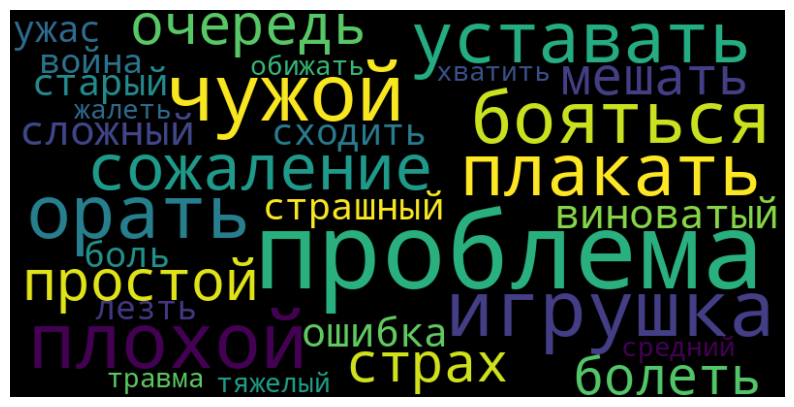

In [25]:
draw_cloud(negative_words_freq)

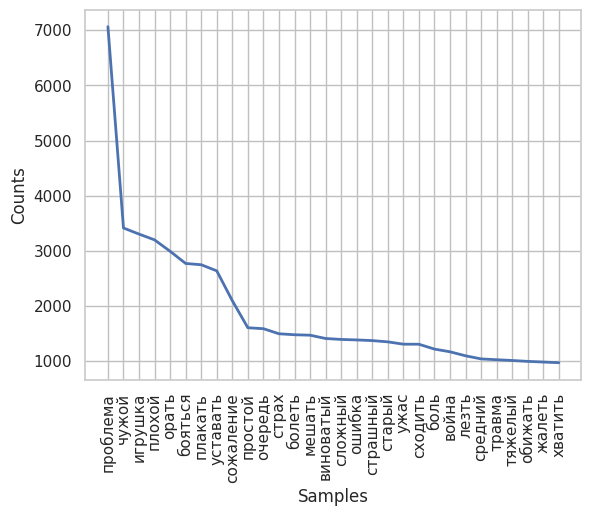

In [26]:
draw_plot(negative_words_freq)

Применим функции для слов с положительной оценкой

In [27]:
positive_words_freq = counting_sentiment_freq(comments, 'positive')

In [28]:
positive_words_freq_table = pd.DataFrame(positive_words_freq)
positive_words_freq_table

,lemma,absolute_freq,relative_freq
0,понимать,18020,0.071766
1,хороший,9806,0.039053
2,любить,9798,0.039021
3,помогать,8490,0.033812
4,друг,6574,0.026182
5,любовь,4488,0.017874
6,пример,3610,0.014377
7,нравиться,3499,0.013935
8,прямой,3480,0.013859
9,помощь,3150,0.012545


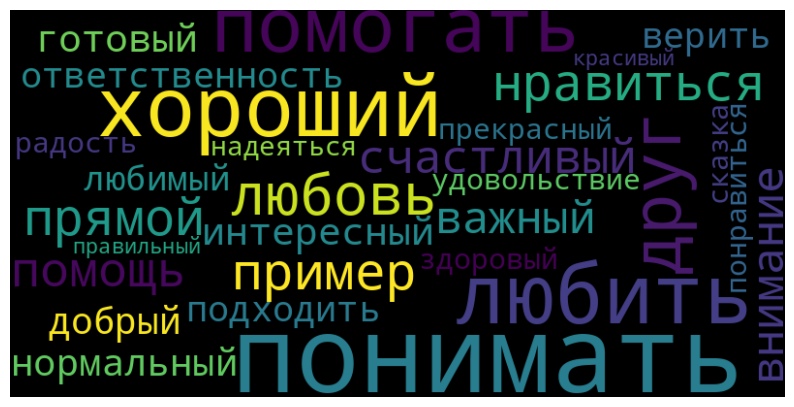

In [29]:
draw_cloud(positive_words_freq)

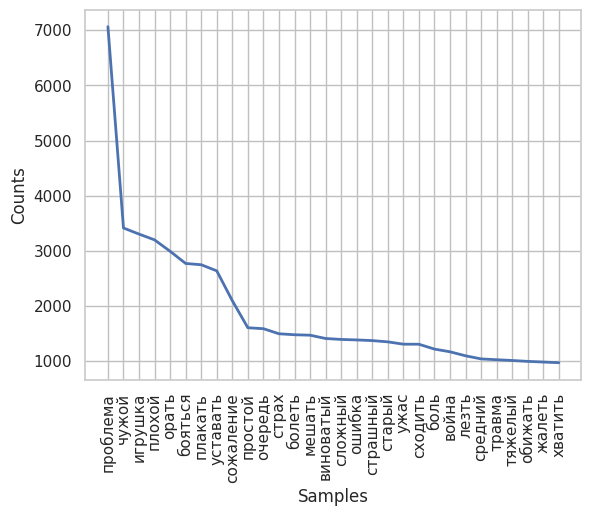

In [30]:
draw_plot(negative_words_freq)

Анализ всего комментария. Для этого используем библиотеку nltk

In [31]:
def sentiment_comment_analyse(cleaned_text):
    try:
       analysis = TextBlob(cleaned_text)
       sentiment_score = analysis.sentiment.polarity
       if sentiment_score > 0:
           sentiment = 'positive'
       elif sentiment_score < 0:
           sentiment = 'negative'
       else:
           sentiment = 'neutral'
       return sentiment
    except:
        None

In [32]:
comments['sentiment_comment'] = comments['cleaned_text'].apply(sentiment_comment_analyse)

In [33]:
# Количество комментариев каждого типа
total_comments = len(comments)
neutral_count = len(comments[comments['sentiment_comment'] == 'neutral'])
positive_count = len(comments[comments['sentiment_comment'] == 'positive'])
negative_count = len(comments[comments['sentiment_comment'] == 'negative'])

print(f"Всего комментариев: {total_comments}")
print(f"Количество нейтральных комментариев: {neutral_count}")
print(f"Количество положительных комментариев: {positive_count}")
print(f"Количество отрицательных комментариев: {negative_count}")

Всего комментариев: 215239
Количество нейтральных комментариев: 212162
Количество положительных комментариев: 89
Количество отрицательных комментариев: 32


In [34]:
# Относительная частота
neutral_freq = neutral_count / total_comments
positive_freq = positive_count / total_comments
negative_freq = negative_count / total_comments

print(f"Относительная частота нейтральных комментариев: {neutral_freq}")
print(f"Относительная частота положительных комментариев: {positive_freq}")
print(f"Относительная частота отрицательных комментариев: {negative_freq}")

Относительная частота нейтральных комментариев: 0.9857042636325202
Относительная частота положительных комментариев: 0.0004134938370834282
Относительная частота отрицательных комментариев: 0.00014867194142325507
